In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from skimage.feature import hog
from sklearn.utils import shuffle

import pandas as pd  
from keras.models import Sequential
from keras.models import Model
from keras.layers import ELU
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Lambda
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras.models import model_from_json

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import simplejson as json


Using TensorFlow backend.


In [3]:
def showGrayImage(img):
    imgShow = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    imgShow[:,:,2] = imgShow[:,:,0]*255
    imgShow[:,:,0:2] = 0    
    
    plt.imshow(imgShow)            
    plt.show()

In [10]:
rootDir = "object-detection-crowdai"
csvFile = pd.read_csv(rootDir+'/labels.csv', header=0)
dataFile = csvFile[(csvFile['Label']!='Pedestrian')].reset_index()
dataFile = dataFile.drop('index', 1)
dataFile = dataFile.drop('Preview URL', 1)
dataFile['Frame'] = './'+rootDir+'/'+dataFile['Frame']
dataFile.head()

rootDir = "object-dataset"
csvFile1 = pd.read_csv(rootDir+'/labels.csv', header=None)
csvFile1.columns= ['Frame',  'xmin', 'xmax', 'ymin','ymax', 'ind', 'Label','RM']
dataFile1 = csvFile1[(csvFile1['Label']!='Pedestrian')].reset_index()
dataFile1 = dataFile1.drop('index', 1)
dataFile1 = dataFile1.drop('Preview URL', 1)
dataFile1['Frame'] = './'+rootDir+'/'+dataFile1['Frame']
dataFile1.head()




ValueError: Length mismatch: Expected axis has 1 elements, new values have 8 elements

(424, 640, 1)


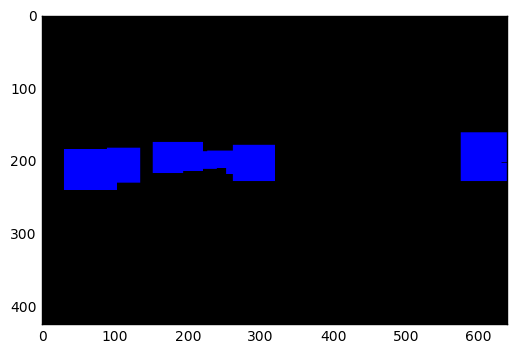

1/1 [==============================] - 0s
prediction


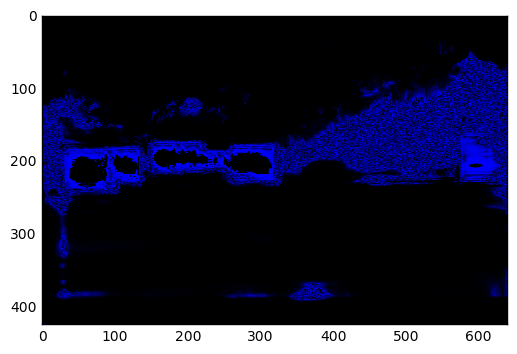

In [24]:
train_samples_per_epoch = 2560
valid_samples_per_epoch = 16384
trainBatchSize = 64
validationBatchSize = 64
imgRow = 424
imgCol = 640
def TrainDataGenerator(dataInfo,batchSize,rootDir):
    batch_x, batch_y = [], []
    while True:
        row = 0
        while row < len(dataInfo):

            fileName = './'+rootDir + '/' +dataInfo['Frame'][row]        
            #print(fileName, row)
            img = cv2.imread(fileName)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            origShape = img.shape
            img = cv2.resize(img,(imgCol,imgRow))

            data = dataInfo[dataInfo['Frame'][row] == dataInfo['Frame']].reset_index()
            data['xmin'] = np.round(data['xmin']/origShape[1] * imgCol)
            data['xmax'] = np.round(data['xmax']/origShape[1] * imgCol)
            data['ymin'] = np.round(data['ymin']/origShape[0] * imgRow)
            data['ymax'] = np.round(data['ymax']/origShape[0] * imgRow)


            targetImg = np.reshape(np.zeros_like(img[:,:,2]),(imgRow,imgCol,1))            
            for i in range(len(data)):
                targetImg[data.iloc[i]['xmax']:data.iloc[i]['ymax'],data.iloc[i]['xmin']:data.iloc[i]['ymin']] = 1
                cv2.rectangle(img, (int(data.iloc[i]['xmin']),int(data.iloc[i]['xmax'])), (int(data.iloc[i]['ymin']),int(data.iloc[i]['ymax'])), (0,0,255),6)
                

            row += len(data)-1

            batch_x.append(img)
            batch_y.append(targetImg)
            print(targetImg.shape)
            
            showGrayImage(targetImg)
            
            xy_array = np.asarray(img)
            xy_array = np.reshape(xy_array,(1,imgRow,imgCol,3))

            img = model.predict(xy_array,verbose=1)    
            print('prediction')
            showGrayImage(img[0])
            if(len(batch_x) == batchSize):                
                #yield (np.vstack(batch_x),np.vstack(batch_y))
                x_array = np.asarray(batch_x)
                y_array = np.asarray(batch_y)
                #yield (x_array,y_array)
                batch_x, batch_y = [], []            
            row+=1        
            break
        break
trainGenerator = TrainDataGenerator(dataFile,trainBatchSize,rootDir)    

In [30]:

def CreateModel():
    input_layer = Input((imgRow, imgCol, 3))
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_layer)
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    #conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    #conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up5 = merge([UpSampling2D(size=(2, 2))(conv4), conv3], mode='concat', concat_axis=3)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up5)
    conv5 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv2], mode='concat', concat_axis=3)
    conv6 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv1], mode='concat', concat_axis=3)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv7)
    
    conv8 = Convolution2D(1, 1, 1, activation='sigmoid')(conv7)

    model = Model(input=input_layer, output=conv8)

    model.compile(optimizer=Adam(lr=1e-4), loss="mse", metrics=['accuracy'])

    return model



model = CreateModel()

trainGenerator = TrainDataGenerator(dataFile,trainBatchSize,rootDir)  
#trainGenerator = TrainDataGenerator(trainBatchSize)

weight_save_callback = ModelCheckpoint('./weights/weights.{epoch:02d}-{loss:.4f}.h5', monitor='loss', verbose=2, save_best_only=False, mode='auto')
model.summary()

print("Created generator and call backs. Starting training")

model.fit_generator(
    trainGenerator,
    samples_per_epoch=train_samples_per_epoch, nb_epoch=40,
    #validation_data=validGenerator,
    #nb_val_samples=valid_samples_per_epoch,
    callbacks=[weight_save_callback],
    verbose=2
)

model.save_weights('model.h5', True)
with open('model.json', 'w') as file:
    json.dump(model.to_json(), file)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_14 (InputLayer)            (None, 640, 960, 3)   0                                            
____________________________________________________________________________________________________
convolution2d_196 (Convolution2D (None, 640, 960, 16)  448         input_14[0][0]                   
____________________________________________________________________________________________________
convolution2d_197 (Convolution2D (None, 640, 960, 16)  2320        convolution2d_196[0][0]          
____________________________________________________________________________________________________
maxpooling2d_53 (MaxPooling2D)   (None, 320, 480, 16)  0           convolution2d_197[0][0]          
___________________________________________________________________________________________

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ResourceExhaustedError: OOM when allocating tensor with shape[64,16,640,960]
	 [[Node: Conv2D_196 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Relu_182, convolution2d_197_W/read)]]
	 [[Node: Mean_59/_77 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2035_Mean_59", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Conv2D_196', defined at:
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Program Files\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Program Files\Anaconda3\lib\site-packages\traitlets\config\application.py", line 653, in launch_instance
    app.start()
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\tornado\stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Program Files\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-104684bd3ab9>", line 45, in <module>
    model = CreateModel()
  File "<ipython-input-30-104684bd3ab9>", line 5, in CreateModel
    conv1 = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(conv1)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\topology.py", line 572, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\topology.py", line 635, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\topology.py", line 166, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 475, in call
    filter_shape=self.W_shape)
  File "C:\Program Files\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2627, in conv2d
    x = tf.nn.conv2d(x, kernel, strides, padding=padding)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 396, in conv2d
    data_format=data_format, name=name)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Program Files\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[64,16,640,960]
	 [[Node: Conv2D_196 = Conv2D[T=DT_FLOAT, data_format="NHWC", padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Relu_182, convolution2d_197_W/read)]]
	 [[Node: Mean_59/_77 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_2035_Mean_59", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [23]:
from keras.models import model_from_json

with open('model.json', 'r') as jfile:
    model = model_from_json(json.loads(jfile.read())) 
    print('model loaded')

model.compile(optimizer=Adam(lr=1e-4), loss="mse", metrics=['accuracy'])
weights_file = 'model.h5'
model.load_weights(weights_file)


#result = cv2.addWeighted(dst, 1, newwarp, 0.3, 0)

model loaded


In [10]:
imgRow = 424
imgCol = 640
def process_frame(img):
    #plt.imshow(img)
    #plt.show()
    img = cv2.resize(img,(imgCol,imgRow))    
    x_array = np.asarray(img)
    x_array = np.reshape(x_array,(1,imgRow,imgCol,3))
    
    img = model.predict(x_array,verbose=1)    
    
    imgShow = cv2.cvtColor(img[0],cv2.COLOR_GRAY2RGB)
    
    imgShow[:,:,2] = imgShow[:,:,0]*255
    imgShow[:,:,0:2] = 0    
    
    plt.imshow(imgShow)            
    plt.show()
    return imgShow

1/1 [==============================] - 0s


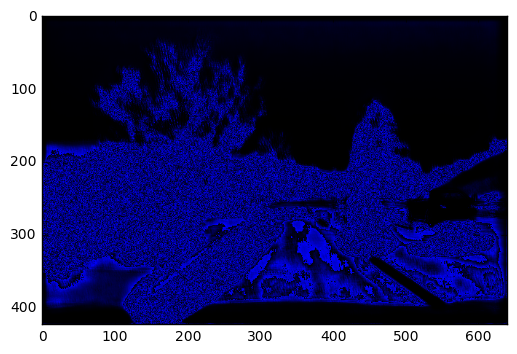

[MoviePy] >>>> Building video ./output_video.mp4
[MoviePy] Writing video ./output_video.mp4


  0%|                                                                                           | 0/39 [00:00<?, ?it/s]

1/1 [==============================] - 0s


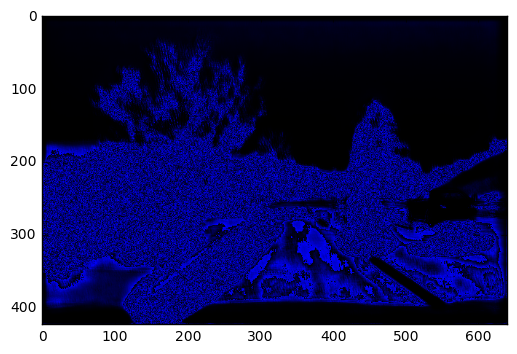

  3%|██▏                                                                                | 1/39 [00:00<00:11,  3.37it/s]

1/1 [==============================] - 0s


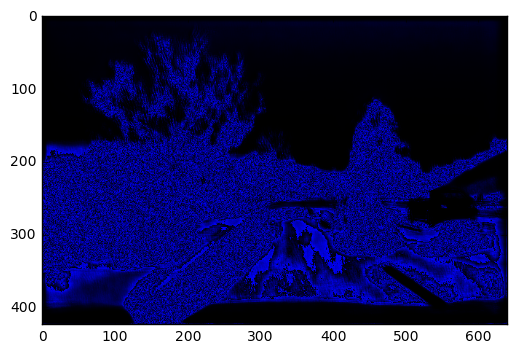

  5%|████▎                                                                              | 2/39 [00:00<00:11,  3.33it/s]

1/1 [==============================] - 0s


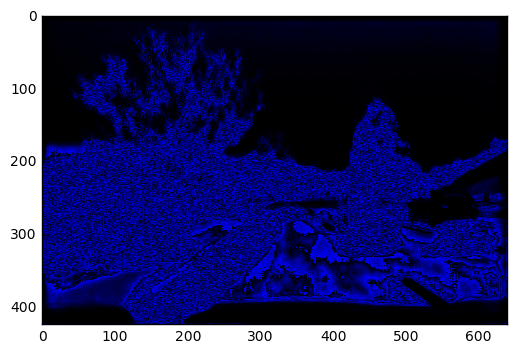

  8%|██████▍                                                                            | 3/39 [00:00<00:10,  3.32it/s]

1/1 [==============================] - 0s


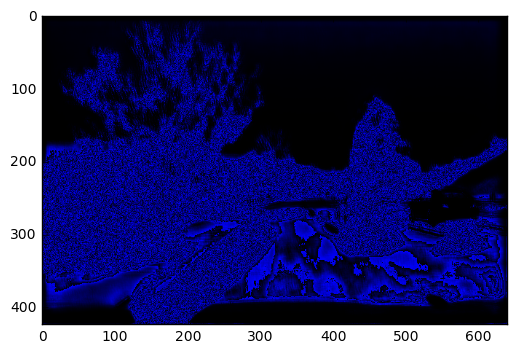

 10%|████████▌                                                                          | 4/39 [00:01<00:10,  3.31it/s]

1/1 [==============================] - 0s


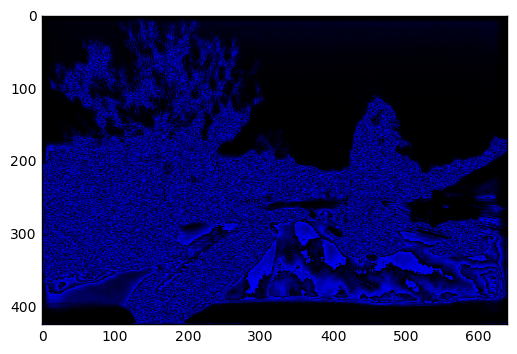

 13%|██████████▋                                                                        | 5/39 [00:01<00:10,  3.31it/s]

1/1 [==============================] - 0s


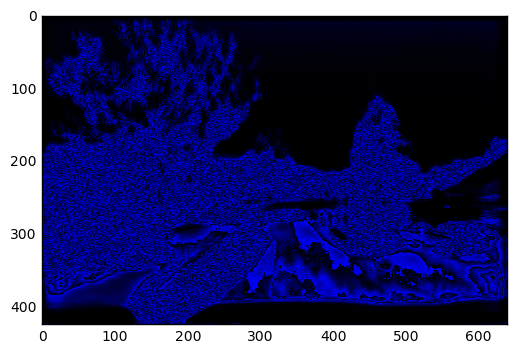

 15%|████████████▊                                                                      | 6/39 [00:01<00:09,  3.31it/s]

1/1 [==============================] - 0s


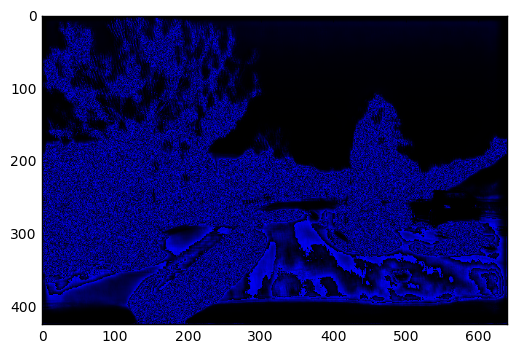

 18%|██████████████▉                                                                    | 7/39 [00:02<00:09,  3.32it/s]

1/1 [==============================] - 0s


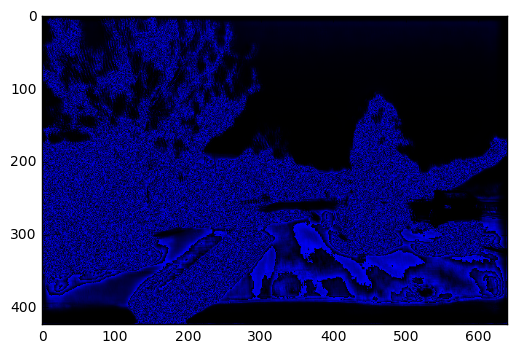

 21%|█████████████████                                                                  | 8/39 [00:02<00:09,  3.31it/s]

1/1 [==============================] - 0s


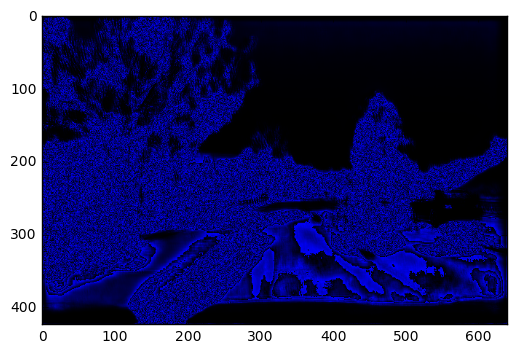

 23%|███████████████████▏                                                               | 9/39 [00:02<00:09,  3.28it/s]

1/1 [==============================] - 0s


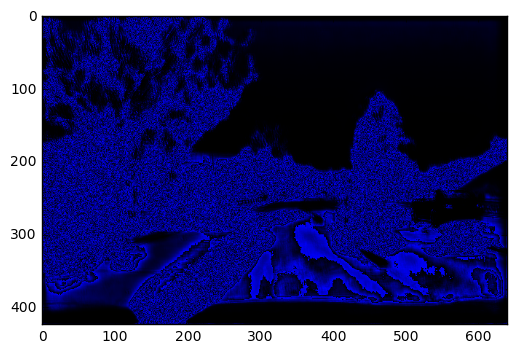

 26%|█████████████████████                                                             | 10/39 [00:03<00:08,  3.29it/s]

1/1 [==============================] - 0s


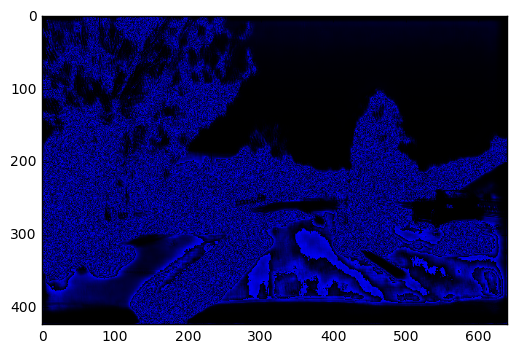

 28%|███████████████████████▏                                                          | 11/39 [00:03<00:08,  3.29it/s]

1/1 [==============================] - 0s


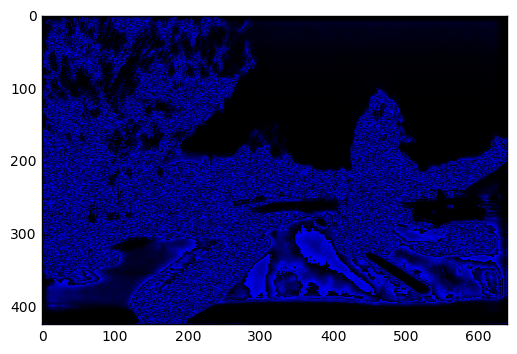

 31%|█████████████████████████▏                                                        | 12/39 [00:03<00:08,  3.31it/s]

1/1 [==============================] - 0s


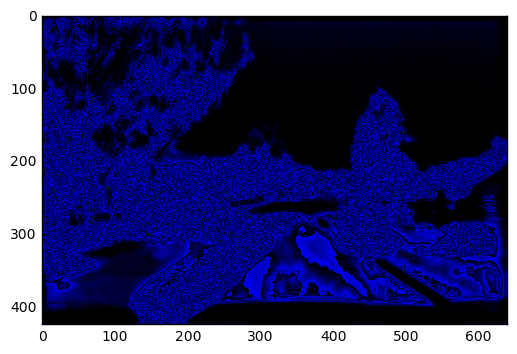

 33%|███████████████████████████▎                                                      | 13/39 [00:03<00:07,  3.30it/s]

1/1 [==============================] - 0s


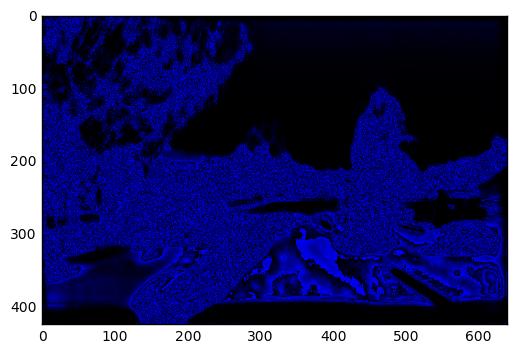

 36%|█████████████████████████████▍                                                    | 14/39 [00:04<00:07,  3.32it/s]

1/1 [==============================] - 0s


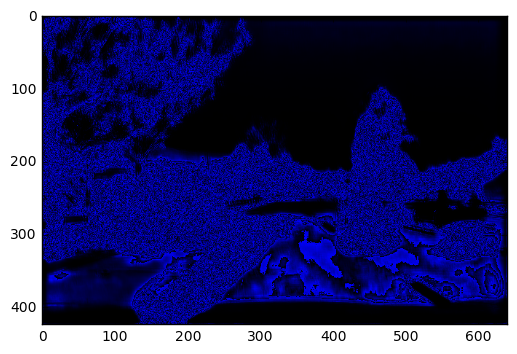

 38%|███████████████████████████████▌                                                  | 15/39 [00:04<00:07,  3.33it/s]

1/1 [==============================] - 0s


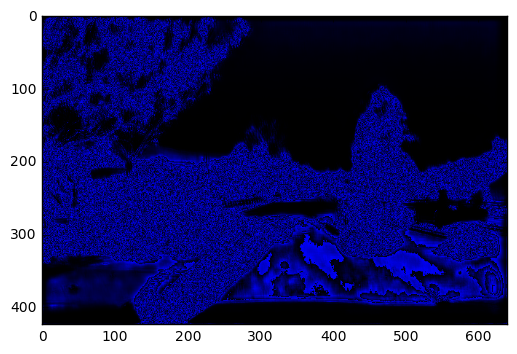

 41%|█████████████████████████████████▋                                                | 16/39 [00:04<00:06,  3.33it/s]

1/1 [==============================] - 0s


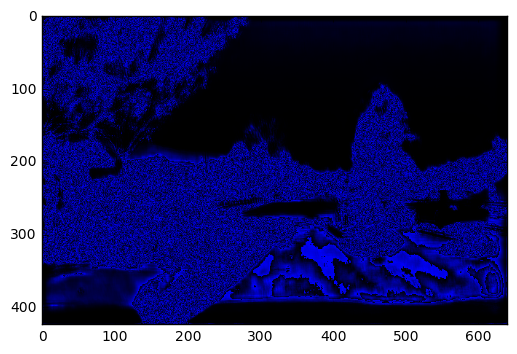

 44%|███████████████████████████████████▋                                              | 17/39 [00:05<00:06,  3.30it/s]

1/1 [==============================] - 0s


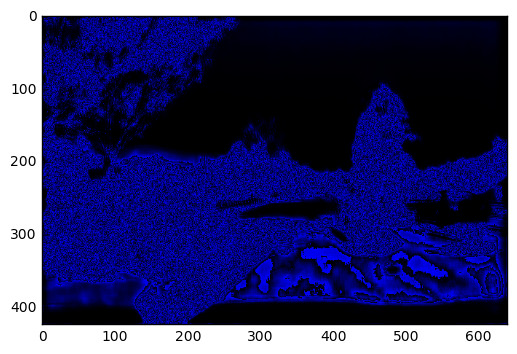

 46%|█████████████████████████████████████▊                                            | 18/39 [00:05<00:06,  3.28it/s]

1/1 [==============================] - 0s


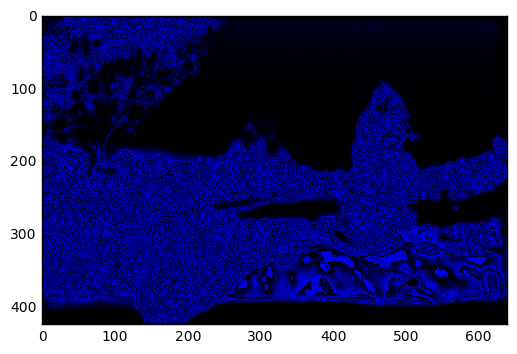

 49%|███████████████████████████████████████▉                                          | 19/39 [00:05<00:06,  2.92it/s]

1/1 [==============================] - 0s


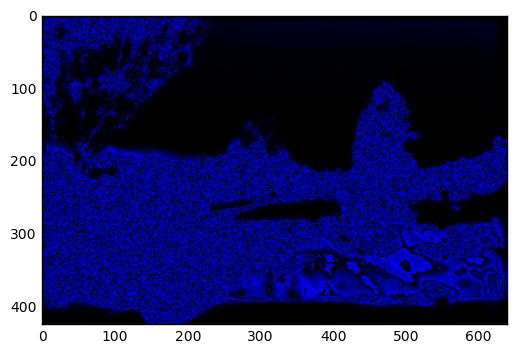

 51%|██████████████████████████████████████████                                        | 20/39 [00:06<00:06,  3.02it/s]

1/1 [==============================] - 0s


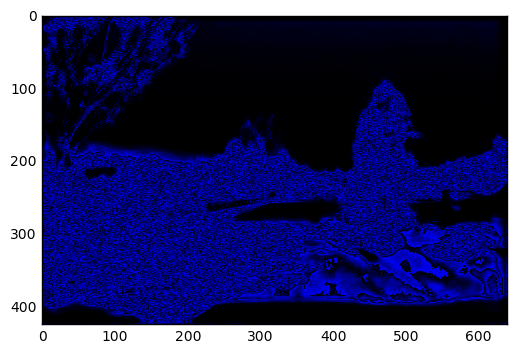

 54%|████████████████████████████████████████████▏                                     | 21/39 [00:06<00:05,  3.13it/s]

1/1 [==============================] - 0s


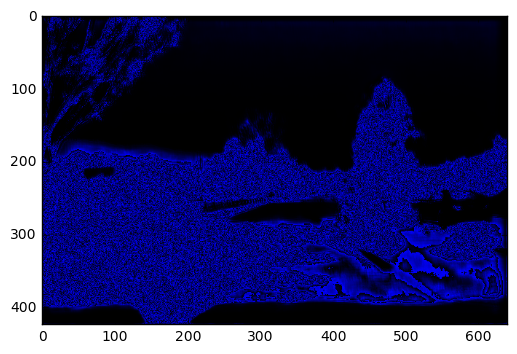

 56%|██████████████████████████████████████████████▎                                   | 22/39 [00:06<00:05,  3.20it/s]

1/1 [==============================] - 0s


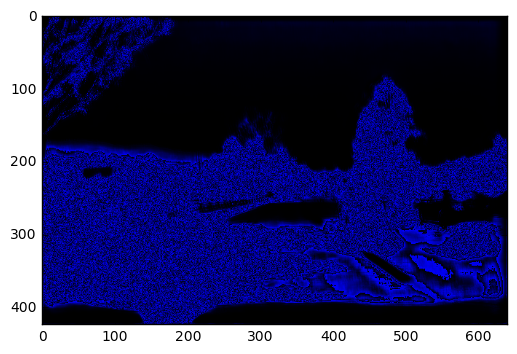

 59%|████████████████████████████████████████████████▎                                 | 23/39 [00:07<00:04,  3.28it/s]

1/1 [==============================] - 0s


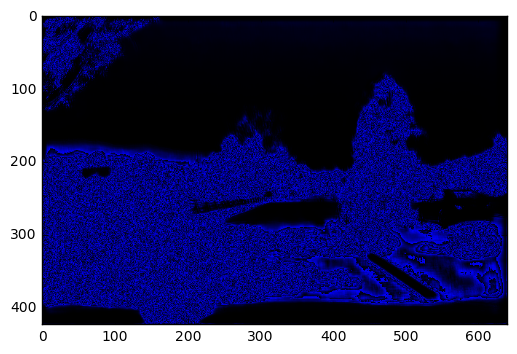

 62%|██████████████████████████████████████████████████▍                               | 24/39 [00:07<00:04,  3.35it/s]

1/1 [==============================] - 0s


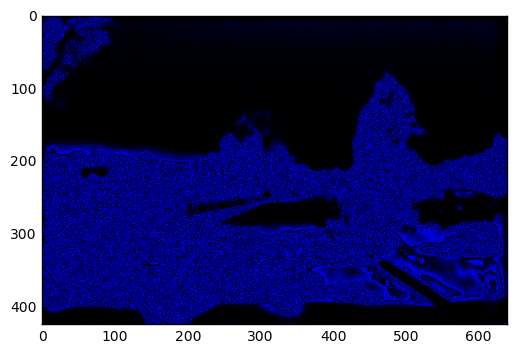

 64%|████████████████████████████████████████████████████▌                             | 25/39 [00:07<00:04,  3.38it/s]

1/1 [==============================] - 0s


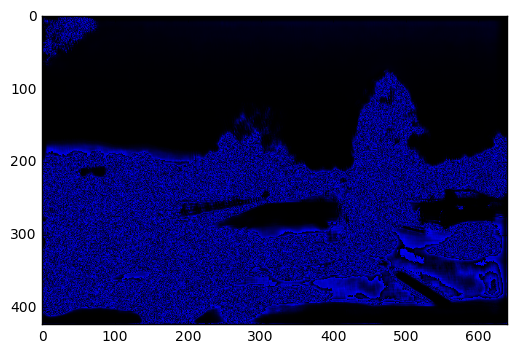

 67%|██████████████████████████████████████████████████████▋                           | 26/39 [00:07<00:03,  3.42it/s]

1/1 [==============================] - 0s


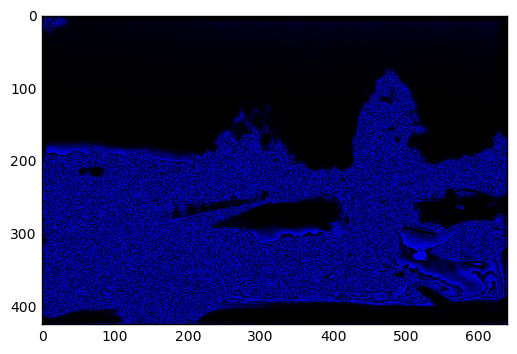

 69%|████████████████████████████████████████████████████████▊                         | 27/39 [00:08<00:03,  3.43it/s]

1/1 [==============================] - 0s


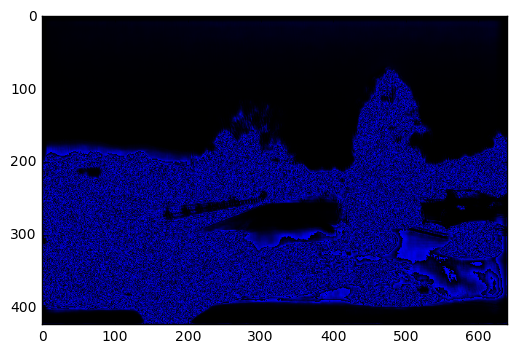

 72%|██████████████████████████████████████████████████████████▊                       | 28/39 [00:08<00:03,  3.46it/s]

1/1 [==============================] - 0s


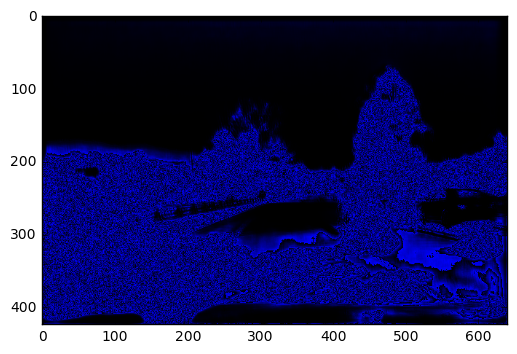

 74%|████████████████████████████████████████████████████████████▉                     | 29/39 [00:08<00:02,  3.45it/s]

1/1 [==============================] - 0s


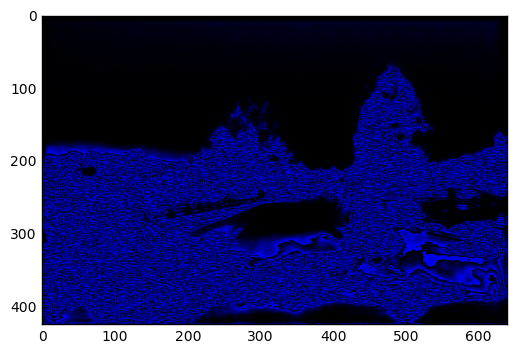

 77%|███████████████████████████████████████████████████████████████                   | 30/39 [00:09<00:02,  3.44it/s]

1/1 [==============================] - 0s


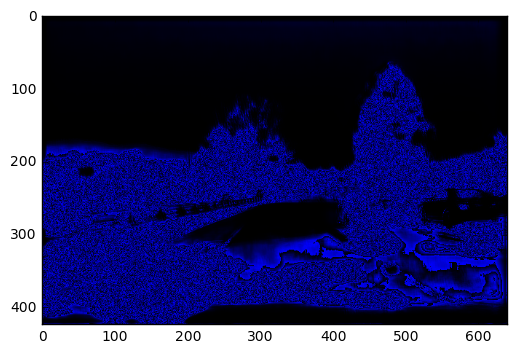

 79%|█████████████████████████████████████████████████████████████████▏                | 31/39 [00:09<00:02,  3.41it/s]

1/1 [==============================] - 0s


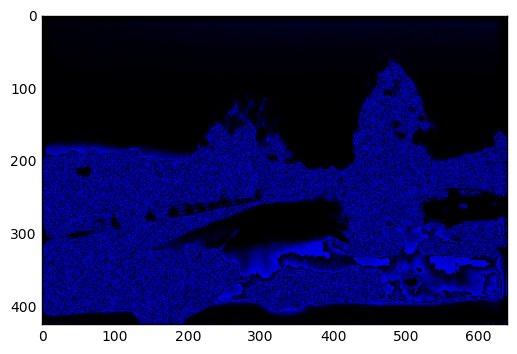

 82%|███████████████████████████████████████████████████████████████████▎              | 32/39 [00:09<00:02,  3.43it/s]

1/1 [==============================] - 0s


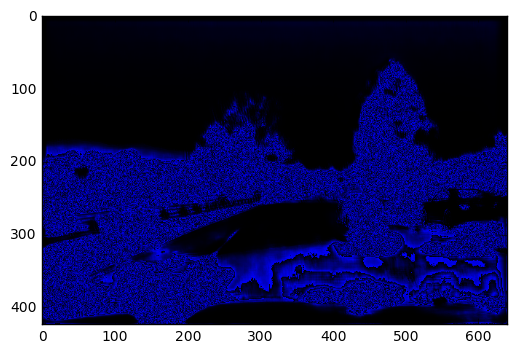

 85%|█████████████████████████████████████████████████████████████████████▍            | 33/39 [00:09<00:01,  3.40it/s]

1/1 [==============================] - 0s


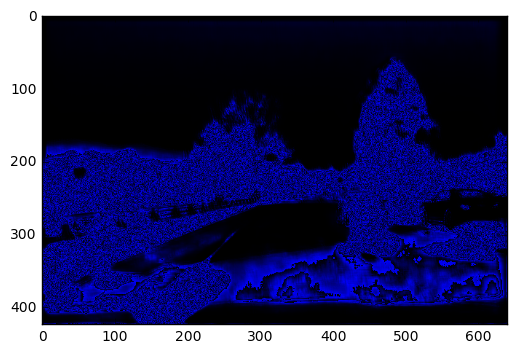

 87%|███████████████████████████████████████████████████████████████████████▍          | 34/39 [00:10<00:01,  3.42it/s]

1/1 [==============================] - 0s


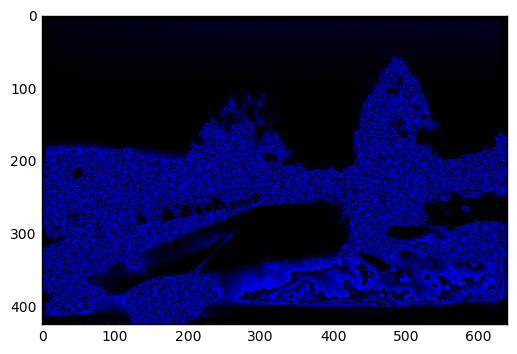

 90%|█████████████████████████████████████████████████████████████████████████▌        | 35/39 [00:10<00:01,  3.46it/s]

1/1 [==============================] - 0s


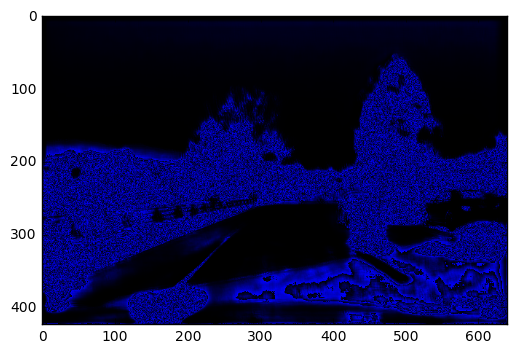

 92%|███████████████████████████████████████████████████████████████████████████▋      | 36/39 [00:10<00:00,  3.48it/s]

1/1 [==============================] - 0s


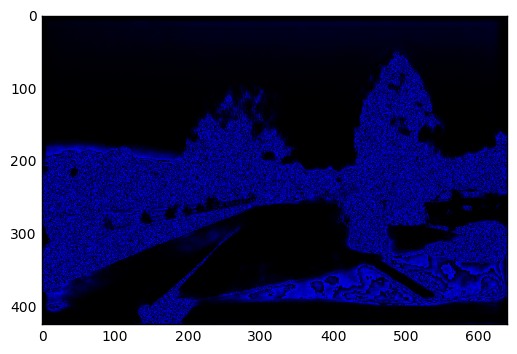

 95%|█████████████████████████████████████████████████████████████████████████████▊    | 37/39 [00:11<00:00,  3.50it/s]

1/1 [==============================] - 0s


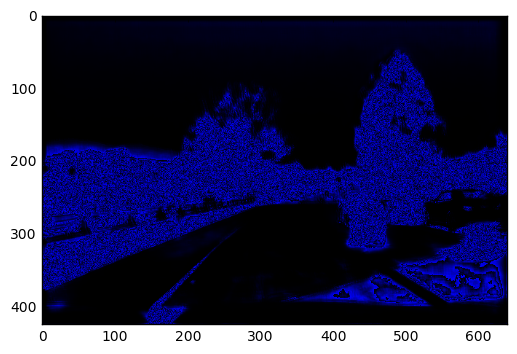

 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:11<00:00,  3.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video.mp4 



In [15]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip('./test_video.mp4')
outClip = clip.fl_image(process_frame)
outClip.write_videofile('./output_video.mp4', audio=False)